In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae

archives = ['../../ecotype_vs_chiclet/nantes_2020-06-04_199415.zip', '../../ecotype_vs_chiclet/lille_2020-06-04_1750953.zip']

f6e1abe82ebba1eec668652189985c631c10b5b5


In [2]:
df = pandas.concat([ae.read_performance(f) for f in archives])
df['mnk'] = df.m * df.n * df.k
df['gflops'] = 2*df['mnk'] / df['duration'] * 1e-9
df['cpu_id'] = df['node'].astype(str) + ':' + df['cpu'].astype(str)
print(len(df))
df.head()

87200


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,mnk,gflops,cpu_id
0,dgemm,572,622,9370,349.776190,0.450396,0,8,ecotype,199415,0,1591256072,0,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,3333696080,14.803403,8:0
1,dgemm,5367,2633,472,350.226617,0.785938,0,8,ecotype,199415,0,1591256072,1,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,6669978792,16.973291,8:0
2,dgemm,3188,445,933,351.012567,0.167027,0,8,ecotype,199415,0,1591256072,2,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1323609780,15.849014,8:0
3,dgemm,1020,1286,256,351.179607,0.041547,0,8,ecotype,199415,0,1591256072,3,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,335800320,16.164666,8:0
4,dgemm,771,1445,2103,351.221168,0.298906,0,8,ecotype,199415,0,1591256072,4,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2342941785,15.676785,8:0


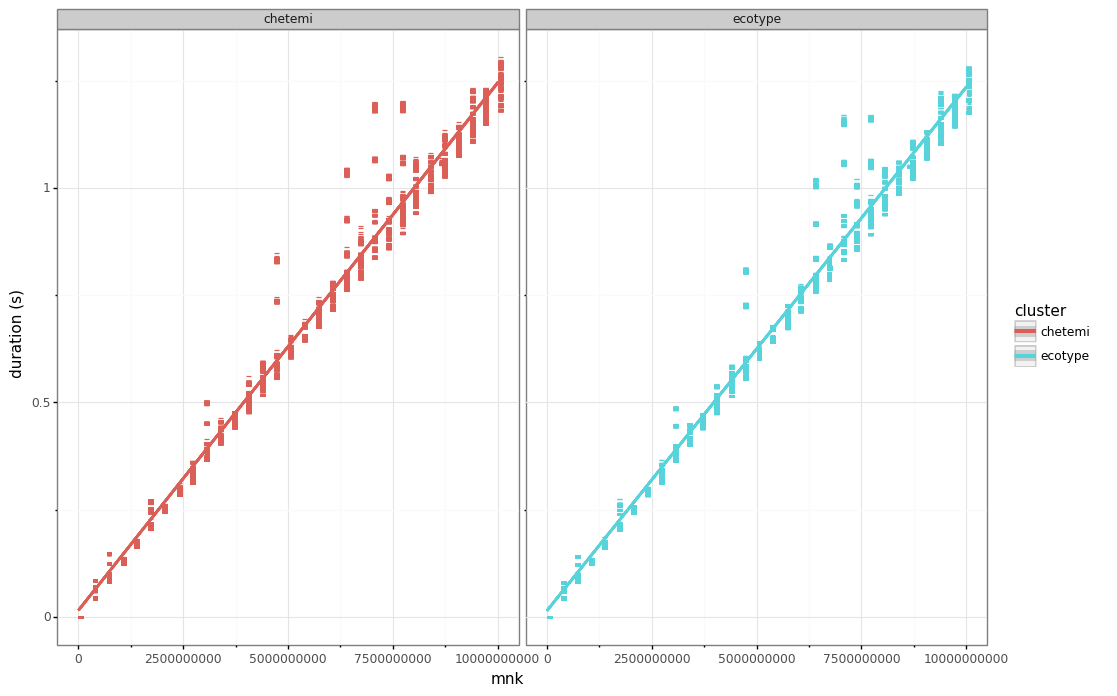

<ggplot: (-9223363284121760182)>

In [3]:
ggplot(df) +\
    aes(x='mnk', y='duration', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    geom_smooth(method='lm') +\
    facet_wrap('cluster') +\
    ylab('duration (s)') +\
    theme_bw()

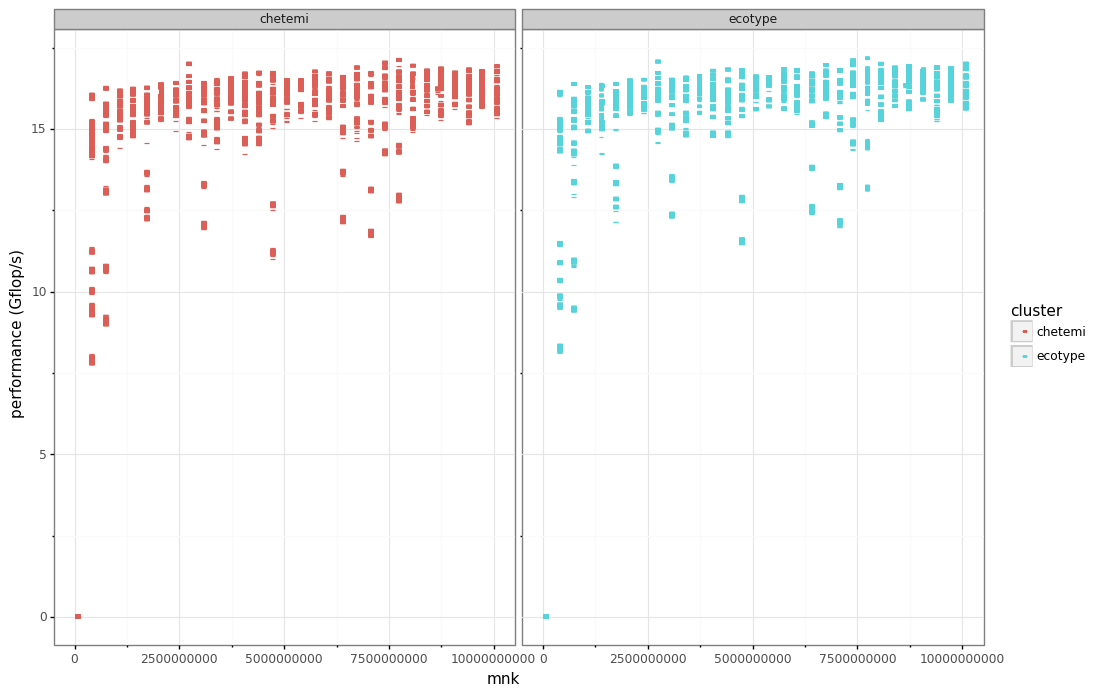

<ggplot: (8752728467190)>

In [4]:
ggplot(df) +\
    aes(x='mnk', y='gflops', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('performance (Gflop/s)') +\
    theme_bw()

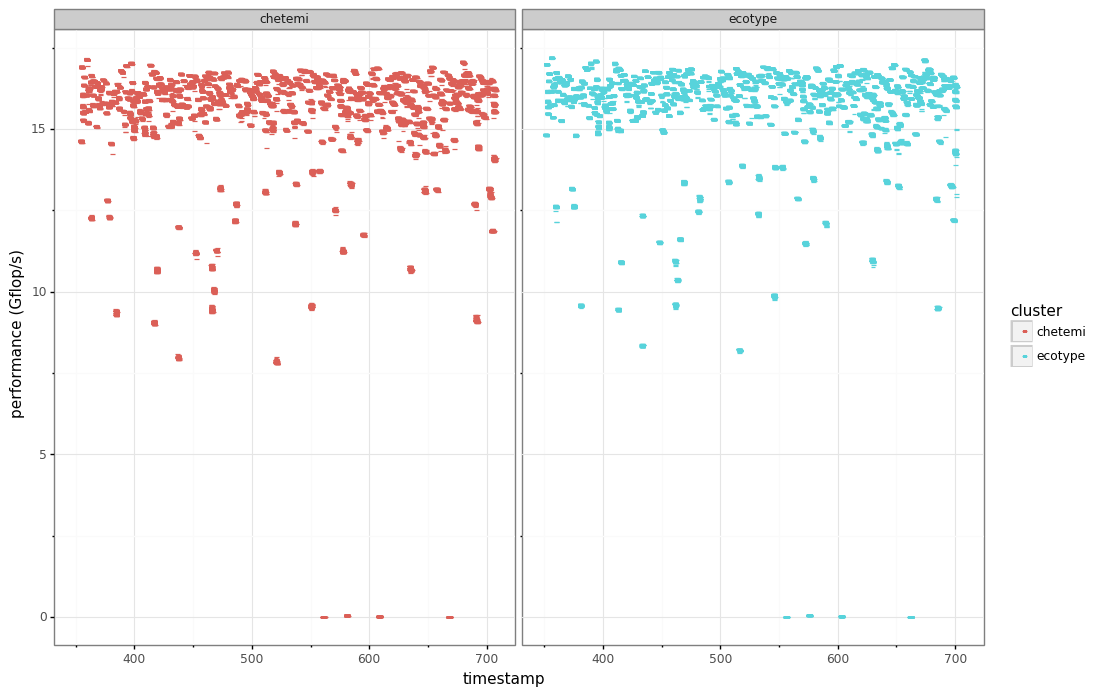

<ggplot: (-9223363284164645411)>

In [5]:
ggplot(df) +\
    aes(x='timestamp', y='gflops', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('performance (Gflop/s)') +\
    theme_bw()

In [6]:
monitoring = pandas.concat([ae.read_monitoring(f) for f in archives])
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
print(len(monitoring))
monitoring.head()

47600


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,cpu_id
0,1.591264e+09,ecotype,8,199415,1591256072,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.452722,0,0,frequency,1.591264e+09,1.591265e+09,8:0
1,1.591264e+09,ecotype,8,199415,1591256072,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.999951,0,0,frequency,1.591264e+09,1.591265e+09,8:0
2,1.591264e+09,ecotype,8,199415,1591256072,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.583679,0,0,frequency,1.591264e+09,1.591265e+09,8:0
3,1.591264e+09,ecotype,8,199415,1591256072,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.355603,0,0,frequency,1.591264e+09,1.591265e+09,8:0
4,1.591264e+09,ecotype,8,199415,1591256072,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.599938,0,0,frequency,1.591264e+09,1.591265e+09,8:0


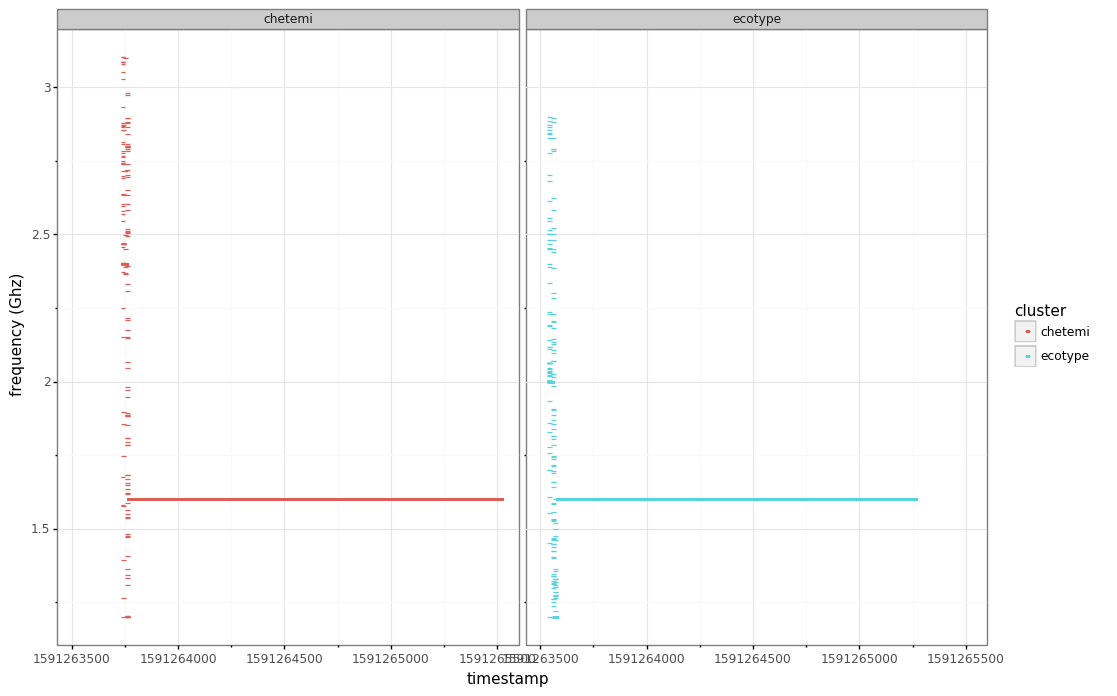

<ggplot: (-9223363284122371398)>

In [7]:
ggplot(monitoring[monitoring['kind'] == 'frequency']) +\
    aes(x='timestamp', y='value', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('frequency (Ghz)') +\
    theme_bw()

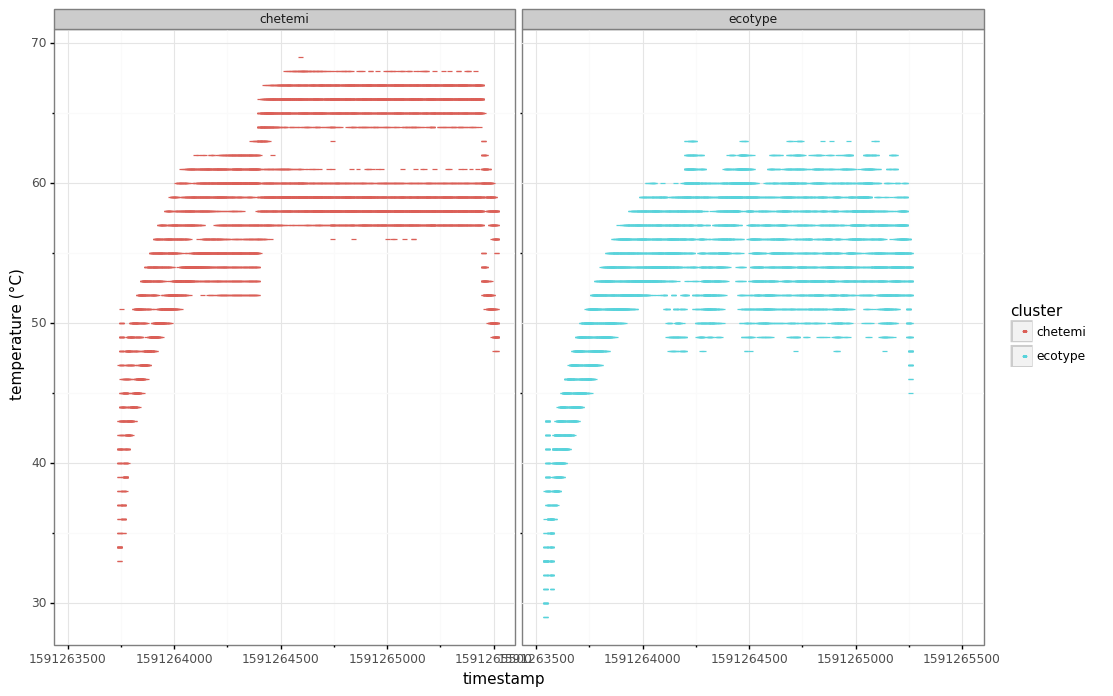

<ggplot: (8752733018856)>

In [8]:
ggplot(monitoring[monitoring['kind'] == 'temperature']) +\
    aes(x='timestamp', y='value', color='cluster', group='cpu_id') +\
    geom_point(shape=1) +\
    facet_wrap('cluster') +\
    ylab('temperature (°C)') +\
    theme_bw()